# NLP with Disaster tweet- basic

Đây là tóm tắt giải pháp cho nhiệm vụ NLP with Disaster tweet-basic:

https://www.kaggle.com/competitions/nlp-getting-started/overviewhttps://www.kaggle.com/competitions/nlp-getting-started/overview

## 1.Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm            
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", index_col ='id')
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", index_col = 'id')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/nlp-getting-started/train.csv'

In [3]:
train_data.shape

(7613, 4)

## 2. Preprocessing

In [4]:
!pip install transformers
import transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
from transformers import BertTokenizer
import tensorflow as tf
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

In [6]:
def bert_encode(data,max_length) :
    input_ids = []
    attention_masks = []  

    for text in data.text:
        encoded = tokenizer.encode_plus(     
            text,
            add_special_tokens = True,
            max_length = max_length,
            pad_to_max_length= True,         
            return_attention_mask = True,
        )    
    
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [7]:
train_input_ids,train_attention_masks = bert_encode(train_data,60)
test_input_ids,test_attention_masks = bert_encode(test_data,60)

In [8]:
len(train_input_ids)

7613

## 3. Model

Dùng mô hình TFBertModel được đào tạo trước từ hugging face

In [9]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def create_model(bert_model):    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 1024), ( 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

In [12]:
history = model.fit([train_input_ids,train_attention_masks],train_data.target,validation_split=0.2, epochs=2,batch_size=10)

Train on 6090 samples, validate on 1523 samples
Epoch 1/2
6090/6090 [==============================] - 192s 32ms/sample - loss: 0.4847 - accuracy: 0.7793 - val_loss: 0.3839 - val_accuracy: 0.8424
Epoch 2/2
6090/6090 [==============================] - 168s 28ms/sample - loss: 0.3666 - accuracy: 0.8562 - val_loss: 0.4242 - val_accuracy: 0.8194


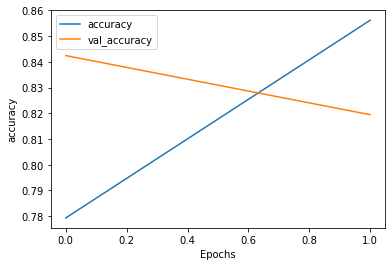

In [13]:
def plot_graphs(history, string):       
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show
    
plot_graphs(history, 'accuracy')

In [14]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

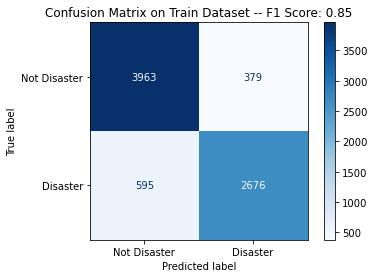

In [15]:
y_train_pred = model.predict([train_input_ids, train_attention_masks])

displayConfusionMatrix(train_data.target, (y_train_pred>0.5).astype(int), "Train")

## 4. Output

In [28]:
y_pred = model.predict([test_input_ids, test_attention_masks])
y_pred = (y_pred>0.5).astype(int).flatten()

In [29]:
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [30]:
output = pd.DataFrame({'id': test_data.index, 'target': y_pred})
output.to_csv('sample_submission1.csv', index = False)

In [31]:
output

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,0
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
